In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np



%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

![CRISP_DM](../reports/figures/CRISP_DM.png)

# Data Load

In [5]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_table.csv',sep=';')  

df_analyse.sort_values('date',ascending=True).head()

,date,Germany,Syria,US,Japan,France,China,Egypt
0,2020-01-22,0,0,1,2,0,548,0
1,2020-01-23,0,0,1,2,0,643,0
2,2020-01-24,0,0,2,2,2,920,0
3,2020-01-25,0,0,2,2,3,1406,0
4,2020-01-26,0,0,5,4,3,2075,0


## Helper Functions

In [6]:
def quick_plot(x_in, df_input,y_scale='log',slider=False):
    """ Quick basic plot for quick static evaluation of a time series
    
        you can push selective columns of your data frame by .iloc[:,[0,6,7,8]]
        
        Parameters:
        ----------
        x_in : array 
            array of date time object, or array of numbers
        df_input : pandas dataframe 
            the plotting matrix where each column is plotted
            the name of the column will be used for the legend
        scale: str
            y-axis scale as 'log' or 'linear'
        slider: bool
            True or False for x-axis slider
    
        
        Returns:
        ----------
        
    """
    fig = go.Figure()

    for each in df_input.columns:
        fig.add_trace(go.Scatter(
                        x=x_in,
                        y=df_input[each],
                        name=each,
                        opacity=0.8))
    
    fig.update_layout(autosize=True,
        width=1000,
        height=600,
        font=dict(
            family="PT Sans, monospace",
            size=18,
            color="#7f7f7f"
            )
        )
    fig.update_yaxes(type=y_scale),
    fig.update_xaxes(tickangle=-45,
                 nticks=20,
                 tickfont=dict(size=14,color="#7f7f7f")
                )
    if slider==True:
        fig.update_layout(xaxis_rangeslider_visible=True)
    fig.show()

In [8]:
quick_plot(df_analyse.date,
           df_analyse.iloc[:,1:],
           y_scale='log',
           slider=False)

In [58]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fitting a polynomial curve

Following this example:
    https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py

In [22]:
# check that all data are there
df_poly_check=df_analyse.iloc[60:,:].reset_index()
df_poly_check.head()

,index,date,Germany,Syria,US,Japan,France,China,Egypt
0,60,2020-03-22,18610,1,34944,1104,16761,81435,327
1,61,2020-03-23,22672,1,46096,1144,20120,81493,366
2,62,2020-03-24,27436,1,56714,1217,22372,81587,402
3,63,2020-03-25,31554,5,68841,1314,25331,81658,456
4,64,2020-03-26,36508,5,86662,1416,29252,81781,495


In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [24]:
y=df_poly_check[['Germany','France','US','Japan']].unstack().sort_index(axis=0,level=1)

In [46]:
y.tail()

US       797    83980356
France   798    29671838
Germany  798    26244107
Japan    798     8804886
US       798    83984644
dtype: int64

In [44]:
y.size

3196

In [85]:
test_points=800
y_train=y[0:-test_points-1]
y_test=y[-test_points:]

In [86]:
y_test.head()

France   599     7358920
Germany  599     4894250
Japan    599     1724379
US       599    46895271
France   600     7362807
dtype: int64

In [87]:
X_train=np.arange(len(y_train)).reshape(-1, 1)/4.0 
X_test=np.arange(len(y_train),len(y_train)+test_points).reshape(-1, 1)/4.0

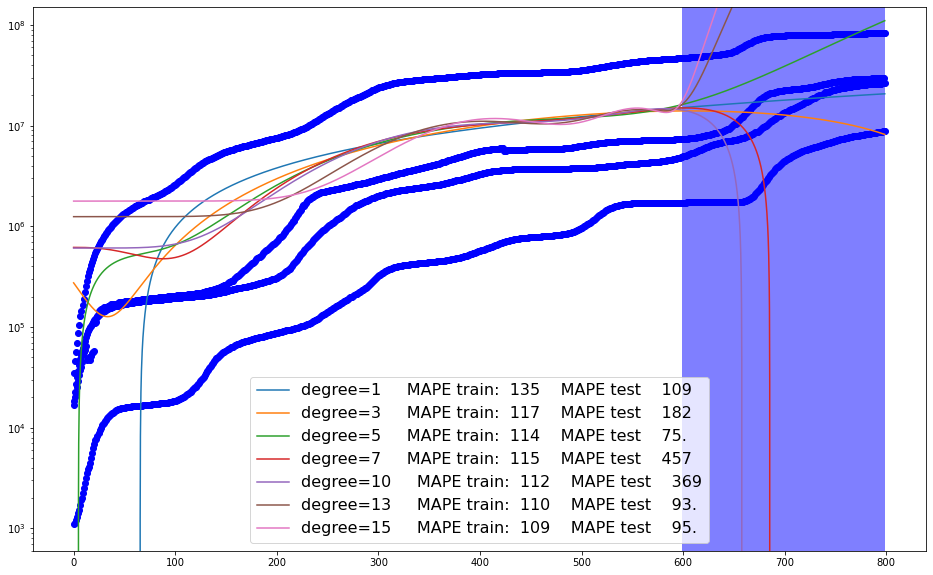

In [88]:
fig, ax1 = plt.subplots(1, 1)

ax1.scatter(np.arange(len(y))/4,y, color='blue')
ax1.axvspan((len(y)-test_points-1)/4, len(y)/4, facecolor='b', alpha=0.5)

for degree in [1,3,5,7,10,13,15]:
    y_hat_insaple=PolynomialRegression(degree).fit(X_train, y_train).predict(X_train)
    y_hat_test = PolynomialRegression(degree).fit(X_train, y_train).predict(X_test)



    X_plot=np.concatenate((X_train, X_test), axis=None)
    y_plot=np.concatenate((y_hat_insaple, y_hat_test), axis=None)

    ax1.plot(X_plot, y_plot, label='degree={0}'.format(degree)+ 
                 '     MAPE train:  ' + str(mean_absolute_percentage_error(y_hat_insaple, y_train))[0:3]
                 +'    MAPE test    ' +str(mean_absolute_percentage_error(y_hat_test, y_test))[0:3]) 

ax1.set_ylim(600, 150000000)
ax1.set_yscale('log')
ax1.legend(loc='best',prop={'size': 16});